In [1]:
import arviz as az
import numpyro
import numpyro.distributions as dist
import jax.random as random
from numpyro.infer import MCMC, NUTS
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import xarray as xr

In [2]:
numpyro.set_host_device_count(4)

In [3]:
np.random.seed(26)

xdata = np.linspace(0, 50, 100)
b0, b1, sigma = -2, 1, 3
ydata = np.random.normal(loc=b1 * xdata + b0, scale=sigma)

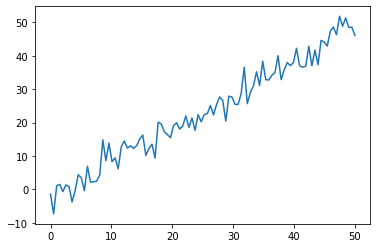

In [4]:
plt.plot(xdata, ydata)

In [5]:
def model(N, x, y=None):
    b0 = numpyro.sample("b0", dist.Normal(0, 10))
    b1 = numpyro.sample("b1", dist.Normal(0, 10))
    sigma_e = numpyro.sample("sigma_e", dist.HalfNormal(10))
    numpyro.sample("y", dist.Normal(b0 + b1 * x, sigma_e), obs=y)

In [6]:
data_dict = {
    "N": len(ydata),
    "y": ydata,
    "x": xdata,
}
kernel = NUTS(model)
sample_kwargs = dict(
    sampler=kernel, 
    num_warmup=1000, 
    num_samples=1000, 
    num_chains=4, 
    chain_method="parallel"
)
mcmc = MCMC(**sample_kwargs)
mcmc.run(random.PRNGKey(0), **data_dict)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [7]:
dims = {"y": ["time"], "x": ["time"]}
idata_kwargs = {
    "dims": dims,
    "constant_data": {"x": xdata}
}
idata = az.from_numpyro(mcmc, **idata_kwargs)
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [8]:
class NumPyroSamplingWrapper(az.SamplingWrapper):
    def __init__(self, model, **kwargs):        
        self.model_fun = model.sampler.model
        self.rng_key = kwargs.pop("rng_key", random.PRNGKey(0))
        
        super(NumPyroSamplingWrapper, self).__init__(model, **kwargs)
        
    def log_likelihood__i(self, excluded_obs, idata__i):
        samples = {
            key: values.values.reshape((-1, *values.values.shape[2:]))
            for key, values 
            in idata__i.posterior.items()
        }
        log_likelihood_dict = numpyro.infer.log_likelihood(
            self.model_fun, samples, **excluded_obs
        )
        if len(log_likelihood_dict) > 1:
            raise ValueError("multiple likelihoods found")
        data = {}
        nchains = idata__i.posterior.dims["chain"]
        ndraws = idata__i.posterior.dims["draw"]
        for obs_name, log_like in log_likelihood_dict.items():
            shape = (nchains, ndraws) + log_like.shape[1:]
            data[obs_name] = np.reshape(log_like.copy(), shape)
        return az.dict_to_dataset(data)[obs_name]
    
    def sample(self, modified_observed_data):
        self.rng_key, subkey = random.split(self.rng_key)
        mcmc = MCMC(**self.sample_kwargs)
        mcmc.run(subkey, **modified_observed_data)
        return mcmc

    def get_inference_data(self, fit):
        # Cloned from PyStanSamplingWrapper.
        idata = az.from_numpyro(mcmc, **self.idata_kwargs)
        return idata
    
class LinRegWrapper(NumPyroSamplingWrapper):
    def sel_observations(self, idx):
        xdata = self.idata_orig.constant_data["x"].values
        ydata = self.idata_orig.observed_data["y"].values
        mask = np.isin(np.arange(len(xdata)), idx)
        data__i = {"x": xdata[~mask], "y": ydata[~mask], "N": len(ydata[~mask])}
        data_ex = {"x": xdata[mask], "y": ydata[mask], "N": len(ydata[mask])}
        return data__i, data_ex

In [9]:
loo_orig = az.loo(idata, pointwise=True)
loo_orig

Computed from 4000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.92     7.20
p_loo        3.10        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [12]:
# now mess some stuff up
loo_orig.pareto_k[[13, 42, 56, 73]] = np.array([0.8, 1.2, 2.6, 0.9])

In [13]:
numpyro_wrapper = LinRegWrapper(
    mcmc, 
    rng_key=random.PRNGKey(5),
    idata_orig=idata, 
    sample_kwargs=sample_kwargs, 
    idata_kwargs=idata_kwargs
)

In [14]:
# now reloo
loo_relooed = az.reloo(numpyro_wrapper, loo_orig=loo_orig, k_thresh=1.0)

/opt/conda/lib/python3.8/site-packages/arviz/stats/stats_refitting.py:99: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [15]:
loo_orig

Computed from 4000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.92     7.20
p_loo        3.10        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       96   96.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         2    2.0%
   (1, Inf)   (very bad)    2    2.0%

In [16]:
loo_relooed

Computed from 4000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.91     7.20
p_loo        3.09        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       98   98.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         2    2.0%
   (1, Inf)   (very bad)    0    0.0%

In [34]:

loo_relooed = reloo(numpyro_wrapper, loo_orig=loo_orig, k_thresh=1.0)

0, dim: time, 100 =? 0


<ipython-input-33-63edb076fefb>:89: UserWarning: reloo is an experimental and untested feature
  warnings.warn("reloo is an experimental and untested feature", UserWarning)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0, dim: time, 100 =? 0


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

0, dim: time, 100 =? 0


In [37]:
from arviz.stats.stats_utils import ELPDData # modify to use relative import
# all([type(loo_orig)==ELPDData])

# loo_orig.loo


In [94]:
from arviz.stats.stats_utils import ELPDData # modify to use relative import

import warnings
from copy import deepcopy
from typing import List, Optional, Tuple, Union, Mapping, cast, Callable

import numpy as np
import pandas as pd
import scipy.stats as st
import xarray as xr
from scipy.optimize import minimize
from typing_extensions import Literal

## set these back to relative imports
from arviz.data import InferenceData, convert_to_dataset, convert_to_inference_data
from arviz.rcparams import rcParams, ScaleKeyword, ICKeyword

from arviz import loo, waic

NO_GET_ARGS: bool = False
try:
    from typing_extensions import get_args
except ImportError:
    NO_GET_ARGS = True
    

def get_ic_type(ic_input):

    try:
        ic_input.loo
        ic = "loo"
    except:
        try:
            ic_input.waic
            ic = "waic"
        except:
            ic = "unknown"
    return(ic)


def _ic_matrix(ics, ic_i):
    """Store the previously computed pointwise predictive accuracy values (ics) in a 2D matrix."""
    cols, _ = ics.shape
    rows = len(ics[ic_i].iloc[0])
    ic_i_val = np.zeros((rows, cols))

    for idx, val in enumerate(ics.index):
        ic = ics.loc[val][ic_i]

        if len(ic) != rows:
            raise ValueError("The number of observations should be the same across all models")

        ic_i_val[:, idx] = ic

    return rows, cols, ic_i_val


def compare(
    dataset_dict: Mapping[str, InferenceData],
    ic: Optional[ICKeyword] = None,
    method: Literal["stacking", "BB-pseudo-BMA", "pseudo-MA"] = "stacking",
    b_samples: int = 1000,
    alpha: float = 1,
    seed=None,
    scale: Optional[ScaleKeyword] = None,
    var_name: Optional[str] = None,
):
    r"""Compare models based on PSIS-LOO `loo` or WAIC `waic` cross-validation.
    LOO is leave-one-out (PSIS-LOO `loo`) cross-validation and
    WAIC is the widely applicable information criterion.
    Read more theory here - in a paper by some of the leading authorities
    on model selection dx.doi.org/10.1111/1467-9868.00353
    Parameters
    ----------
    dataset_dict: dict[str] -> InferenceData
        A dictionary of model names and InferenceData objects
    ic: str, optional
        Information Criterion (PSIS-LOO `loo` or WAIC `waic`) used to compare models. Defaults to
        ``rcParams["stats.information_criterion"]``.
    method: str, optional
        Method used to estimate the weights for each model. Available options are:
        - 'stacking' : stacking of predictive distributions.
        - 'BB-pseudo-BMA' : pseudo-Bayesian Model averaging using Akaike-type
          weighting. The weights are stabilized using the Bayesian bootstrap.
        - 'pseudo-BMA': pseudo-Bayesian Model averaging using Akaike-type
          weighting, without Bootstrap stabilization (not recommended).
        For more information read https://arxiv.org/abs/1704.02030
    b_samples: int, optional default = 1000
        Number of samples taken by the Bayesian bootstrap estimation.
        Only useful when method = 'BB-pseudo-BMA'.
        Defaults to ``rcParams["stats.ic_compare_method"]``.
    alpha: float, optional
        The shape parameter in the Dirichlet distribution used for the Bayesian bootstrap. Only
        useful when method = 'BB-pseudo-BMA'. When alpha=1 (default), the distribution is uniform
        on the simplex. A smaller alpha will keeps the final weights more away from 0 and 1.
    seed: int or np.random.RandomState instance, optional
        If int or RandomState, use it for seeding Bayesian bootstrap. Only
        useful when method = 'BB-pseudo-BMA'. Default None the global
        np.random state is used.
    scale: str, optional
        Output scale for IC. Available options are:
        - `log` : (default) log-score (after Vehtari et al. (2017))
        - `negative_log` : -1 * (log-score)
        - `deviance` : -2 * (log-score)
        A higher log-score (or a lower deviance) indicates a model with better predictive
        accuracy.
    var_name: str, optional
        If there is more than a single observed variable in the ``InferenceData``, which
        should be used as the basis for comparison.
    Returns
    -------
    A DataFrame, ordered from best to worst model (measured by information criteria).
    The index reflects the key with which the models are passed to this function. The columns are:
    rank: The rank-order of the models. 0 is the best.
    IC: Information Criteria (PSIS-LOO `loo` or WAIC `waic`).
        Higher IC indicates higher out-of-sample predictive fit ("better" model). Default LOO.
        If `scale` is `deviance` or `negative_log` smaller IC indicates
        higher out-of-sample predictive fit ("better" model).
    pIC: Estimated effective number of parameters.
    dIC: Relative difference between each IC (PSIS-LOO `loo` or WAIC `waic`)
          and the lowest IC (PSIS-LOO `loo` or WAIC `waic`).
          The top-ranked model is always 0.
    weight: Relative weight for each model.
        This can be loosely interpreted as the probability of each model (among the compared model)
        given the data. By default the uncertainty in the weights estimation is considered using
        Bayesian bootstrap.
    SE: Standard error of the IC estimate.
        If method = BB-pseudo-BMA these values are estimated using Bayesian bootstrap.
    dSE: Standard error of the difference in IC between each model and the top-ranked model.
        It's always 0 for the top-ranked model.
    warning: A value of 1 indicates that the computation of the IC may not be reliable.
        This could be indication of WAIC/LOO starting to fail see
        http://arxiv.org/abs/1507.04544 for details.
    scale: Scale used for the IC.
    Examples
    --------
    Compare the centered and non centered models of the eight school problem:
    .. ipython::
        In [1]: import arviz as az
           ...: data1 = az.load_arviz_data("non_centered_eight")
           ...: data2 = az.load_arviz_data("centered_eight")
           ...: compare_dict = {"non centered": data1, "centered": data2}
           ...: az.compare(compare_dict)
    Compare the models using LOO-CV, returning the IC in log scale and calculating the
    weights using the stacking method.
    .. ipython::
        In [1]: az.compare(compare_dict, ic="loo", method="stacking", scale="log")
    See Also
    --------
    loo : Compute the Pareto Smoothed importance sampling Leave One Out cross-validation.
    waic : Compute the widely applicable information criterion.
    plot_compare : Summary plot for model comparison.
    References
    ----------
    .. [1] Vehtari, A., Gelman, A. & Gabry, J. Practical Bayesian model evaluation using
        leave-one-out cross-validation and WAIC. Stat Comput 27, 1413–1432 (2017)
        see https://doi.org/10.1007/s11222-016-9696-4
    """
    names = list(dataset_dict.keys())
    if scale is not None:
        scale = cast(ScaleKeyword, scale.lower())
    else:
        scale = cast(ScaleKeyword, rcParams["stats.ic_scale"])
    allowable = ["log", "negative_log", "deviance"] if NO_GET_ARGS else get_args(ScaleKeyword)
    if scale not in allowable:
        raise ValueError(f"{scale} is not a valid value for scale: must be in {allowable}")

    if scale == "log":
        scale_value = 1
        ascending = False
    else:
        if scale == "negative_log":
            scale_value = -1
        else:
            scale_value = -2
        ascending = True
## check if it's a loo or waic object here and set ic appropriately 
    is_ic_input = True if all([type(dataset_dict[n])==ELPDData for n in names]) else False
    
    if ic is None:
        ic = cast(ICKeyword, rcParams["stats.information_criterion"])
        if is_ic_input:
            ic = get_ic_type(dataset_dict[names[0]])
    else:
        ic = cast(ICKeyword, ic.lower())
            
    allowable = ["loo", "waic"] if NO_GET_ARGS else get_args(ICKeyword)
    if ic not in allowable:
        raise ValueError(f"{ic} is not a valid value for ic: must be in {allowable}")
        
    if ic == "loo":
        ic_func: Callable = loo
        df_comp = pd.DataFrame(
            index=names,
            columns=[
                "rank",
                "loo",
                "p_loo",
                "d_loo",
                "weight",
                "se",
                "dse",
                "warning",
                "loo_scale",
            ],
            dtype=np.float_,
        )
        scale_col = "loo_scale"
    elif ic == "waic":
        ic_func = waic
        df_comp = pd.DataFrame(
            index=names,
            columns=[
                "rank",
                "waic",
                "p_waic",
                "d_waic",
                "weight",
                "se",
                "dse",
                "warning",
                "waic_scale",
            ],
            dtype=np.float_,
        )
        scale_col = "waic_scale"
    else:
        raise NotImplementedError(f"The information criterion {ic} is not supported.")

    method = rcParams["stats.ic_compare_method"] if method is None else method
    if method.lower() not in ["stacking", "bb-pseudo-bma", "pseudo-bma"]:
        raise ValueError(f"The method {method}, to compute weights, is not supported.")

    ic_se = f"{ic}_se"
    p_ic = f"p_{ic}"
    ic_i = f"{ic}_i"
## if they're loo or waic objects, then skip this fitting and just rearrange 
    ics = pd.DataFrame()
    names = []
    for name, dataset in dataset_dict.items():
        names.append(name)
        if type(dataset)==ELPDData:
            if get_ic_type(dataset)==ic:
                ics = ics.append([dataset])
            else:
                raise ValueError(f"The ic object for {name}, does not match ic type {ic}")
        else:
            try:
                # Here is where the IC function is actually computed -- the rest of this
                # function is argument processing and return value formatting
                ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
            except Exception as e:
                raise e.__class__(f"Encountered error trying to compute {ic} from model {name}.") from e
    ics.index = names
    ics.sort_values(by=ic, inplace=True, ascending=ascending)
    ics[ic_i] = ics[ic_i].apply(lambda x: x.values.flatten())

    if method.lower() == "stacking":
        rows, cols, ic_i_val = _ic_matrix(ics, ic_i)
        exp_ic_i = np.exp(ic_i_val / scale_value)
        km1 = cols - 1

        def w_fuller(weights):
            return np.concatenate((weights, [max(1.0 - np.sum(weights), 0.0)]))

        def log_score(weights):
            w_full = w_fuller(weights)
            score = 0.0
            for i in range(rows):
                score += np.log(np.dot(exp_ic_i[i], w_full))
            return -score

        def gradient(weights):
            w_full = w_fuller(weights)
            grad = np.zeros(km1)
            for k in range(km1):
                for i in range(rows):
                    grad[k] += (exp_ic_i[i, k] - exp_ic_i[i, km1]) / np.dot(exp_ic_i[i], w_full)
            return -grad

        theta = np.full(km1, 1.0 / cols)
        bounds = [(0.0, 1.0) for _ in range(km1)]
        constraints = [
            {"type": "ineq", "fun": lambda x: -np.sum(x) + 1.0},
            {"type": "ineq", "fun": np.sum},
        ]

        weights = minimize(
            fun=log_score, x0=theta, jac=gradient, bounds=bounds, constraints=constraints
        )

        weights = w_fuller(weights["x"])
        ses = ics[ic_se]

    elif method.lower() == "bb-pseudo-bma":
        rows, cols, ic_i_val = _ic_matrix(ics, ic_i)
        ic_i_val = ic_i_val * rows

        b_weighting = st.dirichlet.rvs(alpha=[alpha] * rows, size=b_samples, random_state=seed)
        weights = np.zeros((b_samples, cols))
        z_bs = np.zeros_like(weights)
        for i in range(b_samples):
            z_b = np.dot(b_weighting[i], ic_i_val)
            u_weights = np.exp((z_b - np.max(z_b)) / scale_value)
            z_bs[i] = z_b  # pylint: disable=unsupported-assignment-operation
            weights[i] = u_weights / np.sum(u_weights)

        weights = weights.mean(axis=0)
        ses = pd.Series(z_bs.std(axis=0), index=names)  # pylint: disable=no-member

    elif method.lower() == "pseudo-bma":
        min_ic = ics.iloc[0][ic]
        z_rv = np.exp((ics[ic] - min_ic) / scale_value)
        weights = z_rv / np.sum(z_rv)
        ses = ics[ic_se]

    if np.any(weights):
        min_ic_i_val = ics[ic_i].iloc[0]
        for idx, val in enumerate(ics.index):
            res = ics.loc[val]
            if scale_value < 0:
                diff = res[ic_i] - min_ic_i_val
            else:
                diff = min_ic_i_val - res[ic_i]
            d_ic = np.sum(diff)
            d_std_err = np.sqrt(len(diff) * np.var(diff))
            std_err = ses.loc[val]
            weight = weights[idx]
            df_comp.at[val] = (
                idx,
                res[ic],
                res[p_ic],
                d_ic,
                weight,
                std_err,
                d_std_err,
                res["warning"],
                res[scale_col],
            )

    df_comp["rank"] = df_comp["rank"].astype(int)
    df_comp["warning"] = df_comp["warning"].astype(bool)
    return df_comp.sort_values(by=ic, ascending=ascending)

In [96]:
compare({"loo":loo_orig,"relooed":loo_relooed})

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
relooed,0,-250.908676,3.092848,0.000000,1.0,7.201130,0.000000,False,log
loo,1,-250.919429,3.103601,0.010753,0.0,7.200437,0.007527,False,log


In [61]:
loo_orig

Computed from 4000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -250.92     7.20
p_loo        3.10        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       96   96.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         2    2.0%
   (1, Inf)   (very bad)    2    2.0%